In [467]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [468]:
sns.set_theme()

In [469]:
df = pd.read_csv("data/train.csv")
display(df)

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163


In [470]:
df['date_hour'] = pd.to_datetime(df['date_hour'])

def datetime_preprocessing(df):
    df['hour'] = df['date_hour'].dt.hour
    df['dayofweek'] = df['date_hour'].dt.dayofweek
    df['dayofyear'] = df['date_hour'].dt.dayofyear
    df['weekday_name'] = df['date_hour'].dt.day_name()
    df['week_number'] = df['date_hour'].dt.isocalendar().week
    df['month'] = df['date_hour'].dt.month
    df['month_name'] = df['date_hour'].dt.month_name()
    df['year'] = df['date_hour'].dt.year
    season2011 = pd.cut(df['dayofyear'][df['year'] == 2011], bins=[0, 59, 151, 243, 334, 365], labels=['winter', 'spring', 'summer', 'fall', 'winter'], ordered=False)
    season2012 = pd.cut(df['dayofyear'][df['year'] == 2012], bins=[0, 60, 152, 244, 335, 366], labels=['winter', 'spring', 'summer', 'fall', 'winter'], ordered=False)
    df['season'] = season2011.tolist() + season2012.tolist()
    
    return df

df = datetime_preprocessing(df)
display(df[45:])

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,dayofweek,dayofyear,weekday_name,week_number,month,month_name,year,season
45,2011-01-02 22:00:00,0,1,0.24,0.2121,0.44,0.2985,9,22,6,2,Sunday,52,1,January,2011,winter
46,2011-01-02 23:00:00,0,1,0.22,0.2273,0.47,0.1642,8,23,6,2,Sunday,52,1,January,2011,winter
47,2011-01-03 00:00:00,0,1,0.22,0.1970,0.44,0.3582,5,0,0,3,Monday,1,1,January,2011,winter
48,2011-01-03 01:00:00,0,1,0.20,0.1667,0.44,0.4179,2,1,0,3,Monday,1,1,January,2011,winter
49,2011-01-03 04:00:00,0,1,0.16,0.1364,0.47,0.3881,1,4,0,3,Monday,1,1,January,2011,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,335,Friday,48,11,November,2012,fall
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,335,Friday,48,11,November,2012,fall
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,335,Friday,48,11,November,2012,fall
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,335,Friday,48,11,November,2012,fall


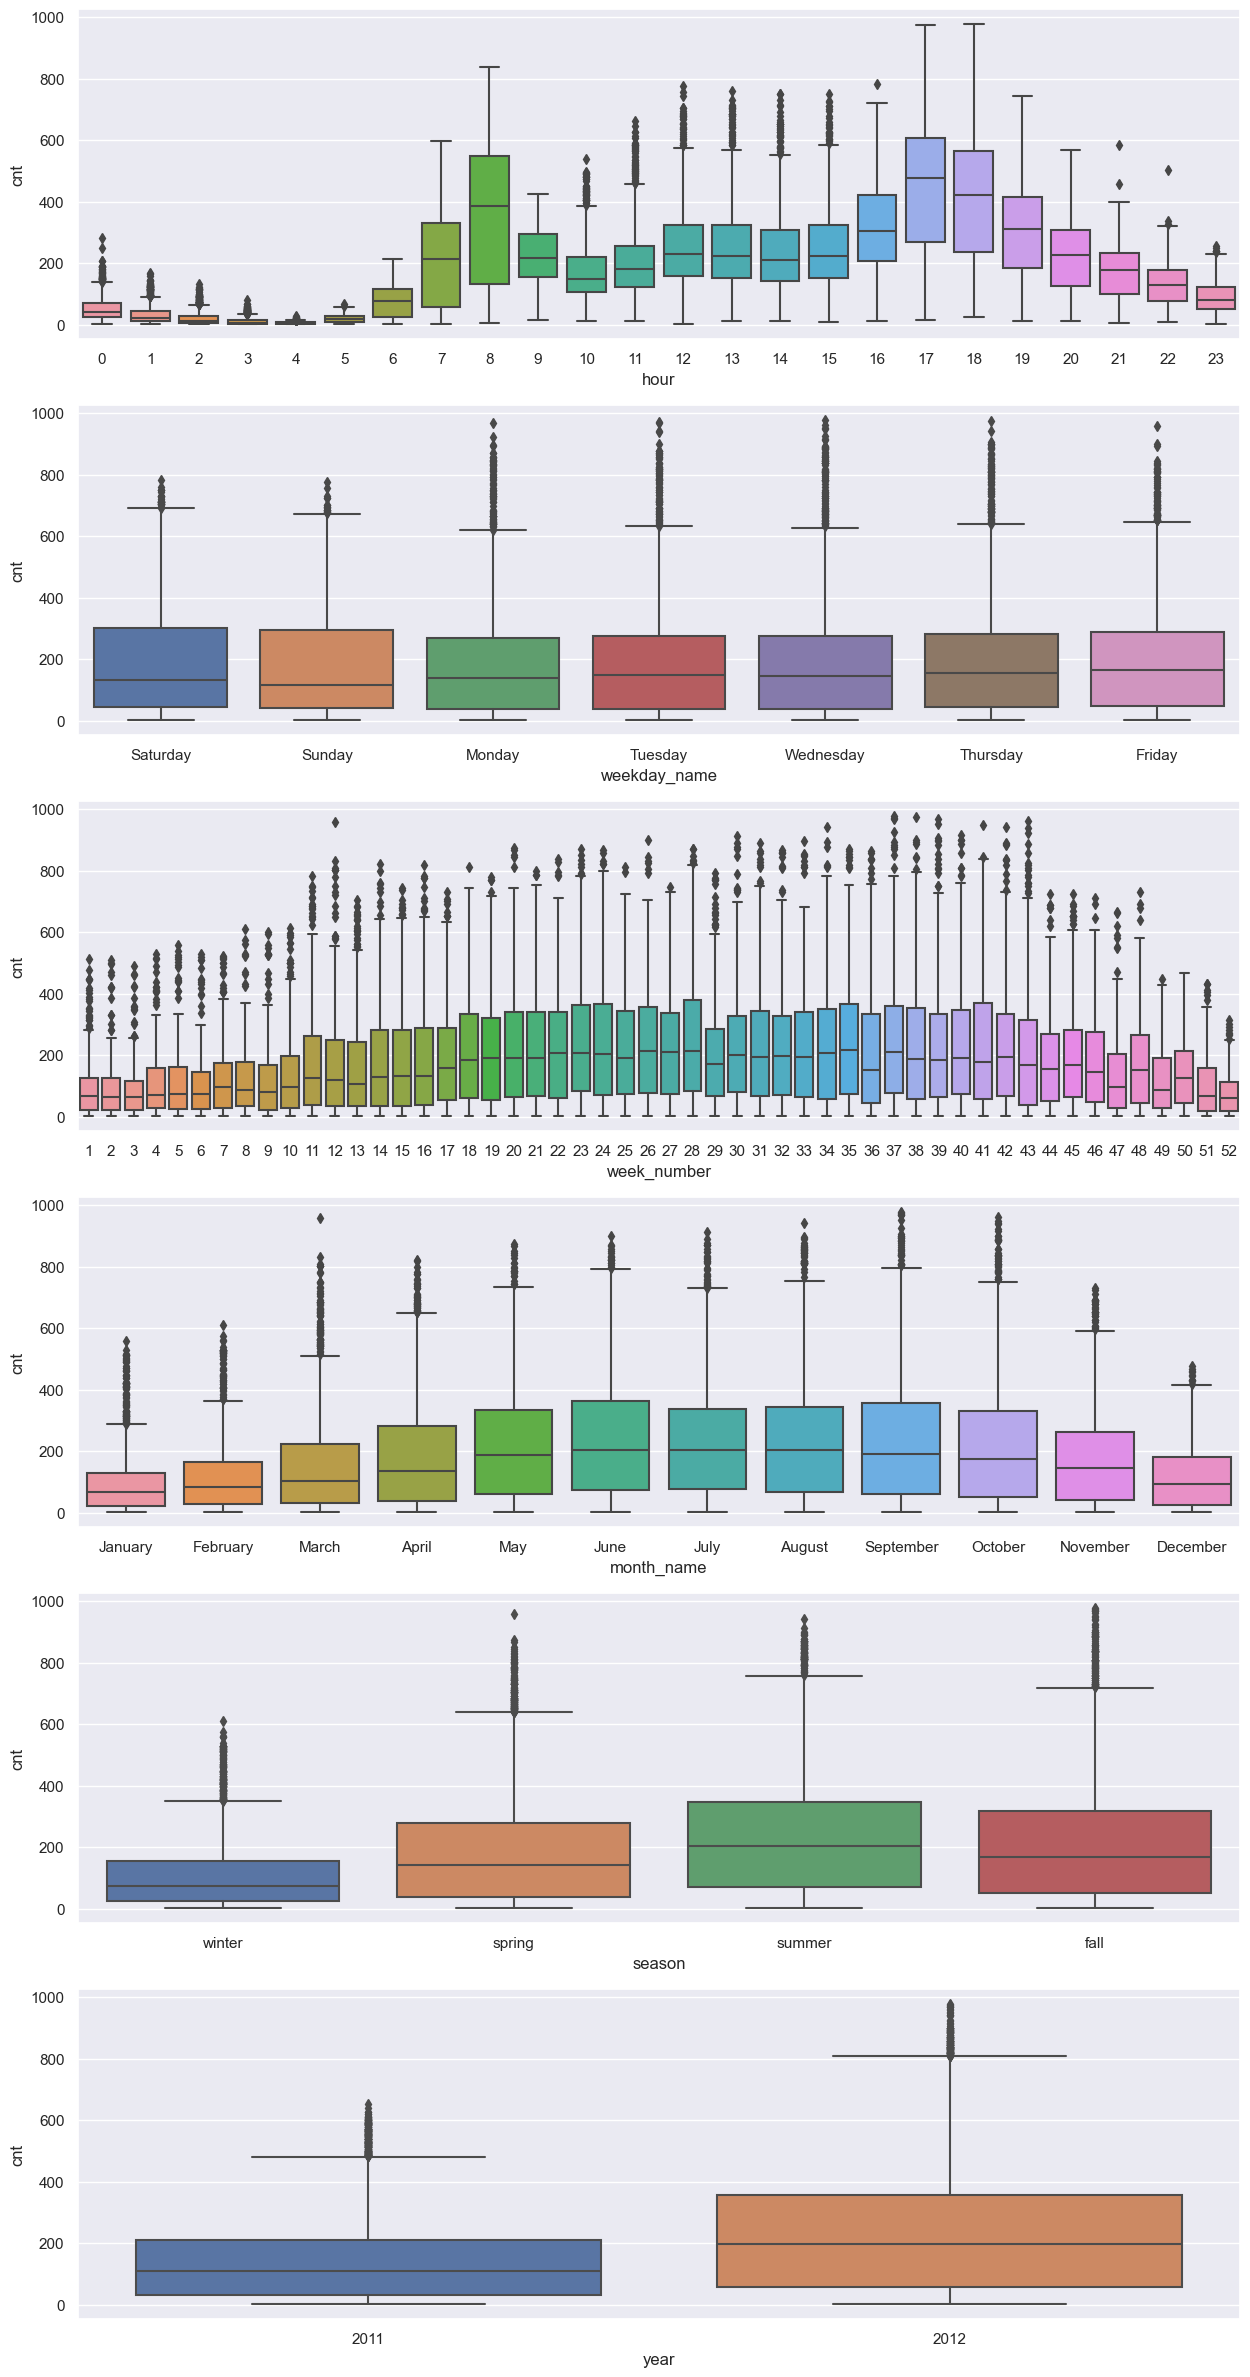

In [471]:
def plot_boxes(df):
    fig, axes = plt.subplots(6, 1, figsize=(15, 30))
    sns.boxplot(data=df, x='hour', y='cnt', ax=axes[0])
    sns.boxplot(data=df, x='weekday_name', y='cnt', ax=axes[1])
    sns.boxplot(data=df, x='week_number', y='cnt', ax=axes[2])
    sns.boxplot(data=df, x='month_name', y='cnt', ax=axes[3])
    sns.boxplot(data=df, x='season', y='cnt', ax=axes[4])
    sns.boxplot(data=df, x='year', y='cnt', ax=axes[5])
    
plot_boxes(df)

In [568]:
def fft_freq(values, threshold):
    fig = plt.figure(figsize=(10, 4))
    
    freq = np.fft.fftfreq(len(values), 1)
    raw_result = np.fft.fft(values)
    
    cleaned_raw_result =  np.array([x if (x >= threshold*10**5) | (x <= -threshold*10**5) else 0 for x in raw_result])
    
    result = np.abs(raw_result)
    
    cleaned_result = np.array([x if (x >= threshold*10**5) & (y > 0) else 0 for x, y in zip(result, freq)])
    
    plt.plot(freq, raw_result)
    plt.xlim([-0.02, 0.13])
    plt.ylim([-5*10**5, 3.5*10**6])
    plt.axhline(threshold*10**5, color='green', dashes=(5, 5))
    
    fft_df = pd.DataFrame({'amplitude':cleaned_result[cleaned_result > 0][1:]})
    fft_df['freq'] = freq[cleaned_result > 0][1:]
    fft_df['duur in uren'] = 1/fft_df['freq']
    fft_df['duur in dagen'] = 1/fft_df['freq']/24
    fft_df['duur in maanden'] = 1/fft_df['freq']/24/(365/12)
    fft_df['duur in jaren'] = 1/fft_df['freq']/24/365
    
    fft_df['freq'] = [fft_df['freq'][0]] + [x if (x-y > x*0.1) else None 
                           for x, y in zip(fft_df['freq'][1:], fft_df['freq'][:-1])]
    
    fft_df = fft_df.dropna().reset_index(drop=True)
    
    
    return fft_df, freq, cleaned_raw_result

C:\Users\Mark\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


,amplitude,freq,duur in uren,duur in dagen,duur in maanden,duur in jaren
0,560236.241034,0.000120,8318.500000,346.604167,11.395205,0.949600
1,217822.744688,0.000180,5545.666667,231.069444,7.596804,0.633067
2,249918.605480,0.000240,4159.250000,173.302083,5.697603,0.474800
3,702799.953019,0.041594,24.041908,1.001746,0.032934,0.002745
4,306064.251401,0.077418,12.916925,0.538205,0.017694,0.001475
5,204856.186038,0.124962,8.002405,0.333434,0.010962,0.000914
6,180934.849803,0.208271,4.801443,0.200060,0.006577,0.000548


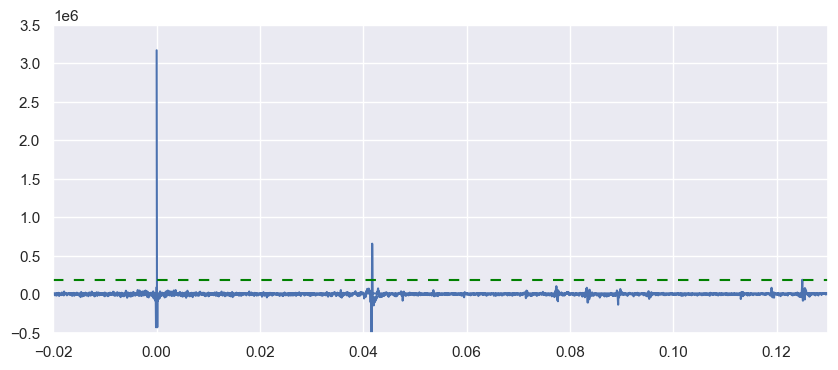

In [569]:
fft_df, freq, result = fft_freq(df['cnt'], 1.8)
display(fft_df)

,date_hour,cnt,week
0,2011-01-01 00:00:00,187.990890,52
1,2011-01-01 01:00:00,184.437853,52
2,2011-01-01 02:00:00,165.951396,52
3,2011-01-01 03:00:00,140.646468,52
4,2011-01-01 04:00:00,120.002589,52
...,...,...,...
16632,2012-11-30 19:00:00,146.349680,48
16633,2012-11-30 20:00:00,138.358083,48
16634,2012-11-30 21:00:00,142.132687,48
16635,2012-11-30 22:00:00,157.456688,48


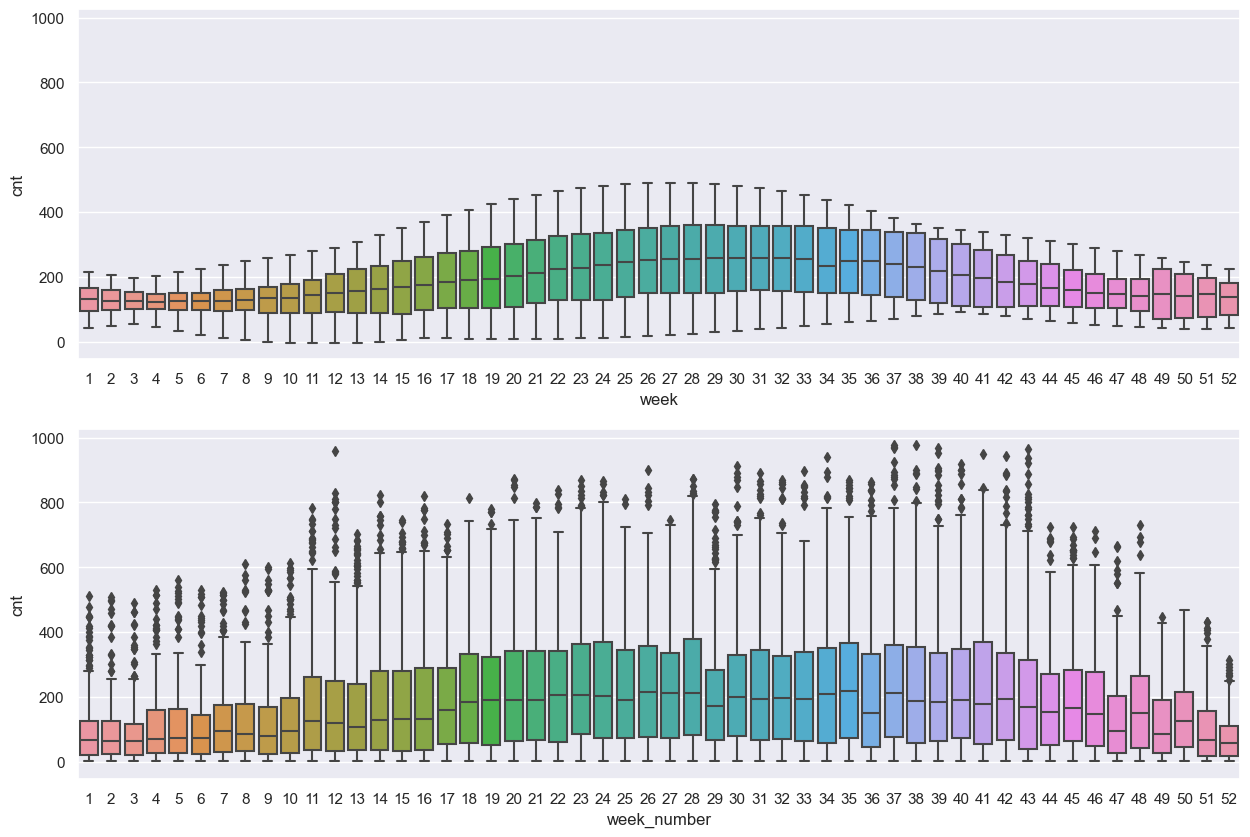

In [542]:
def inverted_fft(freq, result, df):
    cnt = np.fft.ifft(result).real
    
    ifft_df = pd.DataFrame({'date_hour': df['date_hour'], 'cnt': cnt})
    ifft_df['week'] = ifft_df['date_hour'].dt.isocalendar().week

    return ifft_df
    
def compare_ifft(df, ifft_df):
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True)
    sns.boxplot(x=ifft_df['week'], y=ifft_df['cnt'], ax=axes[0])
    sns.boxplot(data=df, x='week_number', y='cnt', ax=axes[1])
    
    
ifft_df = inverted_fft(freq, result, df)
display(ifft_df)

compare_ifft(df, ifft_df)

In [586]:
annual_fourier = CalendarFourier(freq='A', order =  1)
quarterly_fourier = CalendarFourier(freq='Q', order =  1)
daily_fourier = CalendarFourier(freq='D', order = 1)


In [587]:
dp = DeterministicProcess(index=df['date_hour'], constant=False, order=0, seasonal=False,
                          additional_terms = [annual_fourier, quarterly_fourier, daily_fourier], drop = False)

fourier_terms = dp.in_sample().reset_index()
fourier_terms['date_hour'] = pd.to_datetime(fourier_terms['date_hour'])

display(fourier_terms)

,date_hour,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=Q-DEC)","cos(1,freq=Q-DEC)","sin(1,freq=D)","cos(1,freq=D)"
0,2011-01-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2011-01-01 01:00:00,0.000717,1.000000,0.002909,0.999996,0.258819,0.965926
2,2011-01-01 02:00:00,0.001435,0.999999,0.005818,0.999983,0.500000,0.866025
3,2011-01-01 03:00:00,0.002152,0.999998,0.008727,0.999962,0.707107,0.707107
4,2011-01-01 04:00:00,0.002869,0.999996,0.011635,0.999932,0.866025,0.500000
...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,-0.510494,0.859881,-0.846940,-0.531688,-0.965926,0.258819
16633,2012-11-30 20:00:00,-0.509879,0.860246,-0.848450,-0.529276,-0.866025,0.500000
16634,2012-11-30 21:00:00,-0.509263,0.860611,-0.849953,-0.526859,-0.707107,0.707107
16635,2012-11-30 22:00:00,-0.508647,0.860975,-0.851448,-0.524438,-0.500000,0.866025


(14975.0, 14976.0)

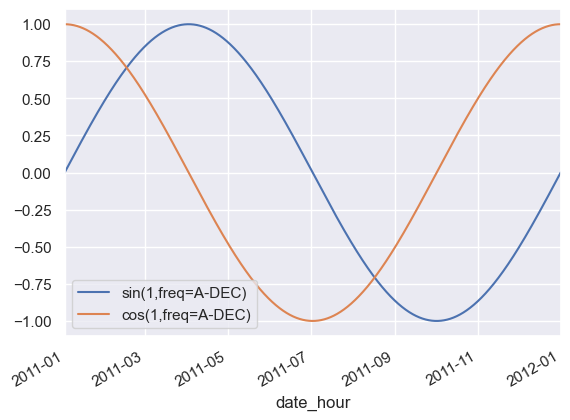

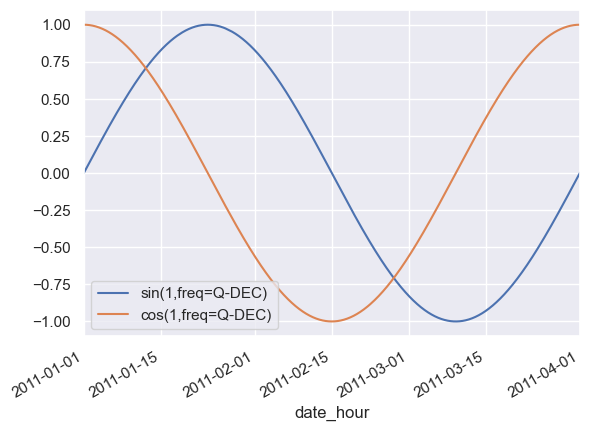

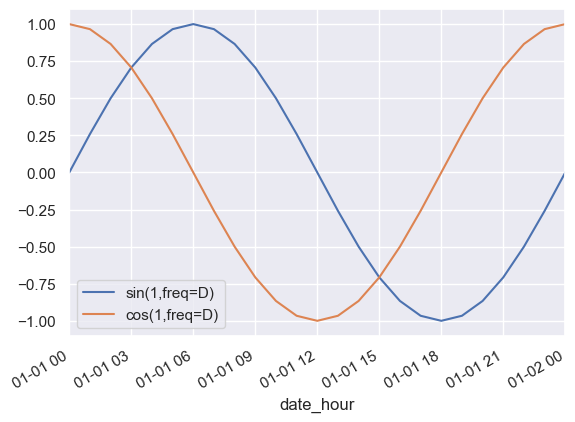

In [588]:
ax = fourier_terms.plot(y='sin(1,freq=A-DEC)', x=('date_hour'))
ax = fourier_terms.plot(ax=ax, y='cos(1,freq=A-DEC)', x=('date_hour'))

year_start_date = pd.to_datetime('2011-01-01')
year_end_date = pd.to_datetime('2012-01-01')

ax.set_xlim(year_start_date, year_end_date)

ax2 = fourier_terms.plot(y='sin(1,freq=Q-DEC)', x=('date_hour'))
ax2 = fourier_terms.plot(ax=ax2, y='cos(1,freq=Q-DEC)', x=('date_hour'))

quarter_start_date = pd.to_datetime('2011-01-01')
quarter_end_date = pd.to_datetime('2011-04-01')

ax2.set_xlim(quarter_start_date, quarter_end_date)

ax3 = fourier_terms.plot(y='sin(1,freq=D)', x=('date_hour'))
ax3 = fourier_terms.plot(ax=ax3, y='cos(1,freq=D)', x=('date_hour'))

day_start_date = pd.to_datetime('2011-01-01')
day_end_date = pd.to_datetime('2011-01-02')

ax3.set_xlim(day_start_date, day_end_date)

In [553]:
 pd.concat([df, fourier_terms], axis=1)

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,dayofweek,...,month_name,year,season,date_hour,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=Q-DEC)","cos(1,freq=Q-DEC)","sin(1,freq=D)","cos(1,freq=D)"
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,...,January,2011,winter,2011-01-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,...,January,2011,winter,2011-01-01 01:00:00,0.000717,1.000000,0.002909,0.999996,0.258819,0.965926
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,...,January,2011,winter,2011-01-01 02:00:00,0.001435,0.999999,0.005818,0.999983,0.500000,0.866025
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,...,January,2011,winter,2011-01-01 03:00:00,0.002152,0.999998,0.008727,0.999962,0.707107,0.707107
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,...,January,2011,winter,2011-01-01 04:00:00,0.002869,0.999996,0.011635,0.999932,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,...,November,2012,fall,2012-11-30 19:00:00,-0.510494,0.859881,-0.846940,-0.531688,-0.965926,0.258819
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,...,November,2012,fall,2012-11-30 20:00:00,-0.509879,0.860246,-0.848450,-0.529276,-0.866025,0.500000
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,...,November,2012,fall,2012-11-30 21:00:00,-0.509263,0.860611,-0.849953,-0.526859,-0.707107,0.707107
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,...,November,2012,fall,2012-11-30 22:00:00,-0.508647,0.860975,-0.851448,-0.524438,-0.500000,0.866025
